# Career Guidance Classification Pipeline
> Code by : Divyansh Goyal

# 1. Introduction
This notebook implements an **end-to-end machine learning classification pipeline** for career guidance prediction.

**Key Features:**
* Comprehensive data inspection and cleaning
*  Multiple visualization techniques for EDA
* Stratified train/test split for balanced evaluation
* 3+ ML algorithms with GridSearchCV hyperparameter tuning
*  Cross-validation based model comparison
*  Extensive metrics: Accuracy, Precision, Recall, F1, Kappa, MCC, ROC-AUC
*  Confusion matrices and multiclass ROC curves
*  Sample predictions with probability scores


# 2. Setup & Configuration

# 2.1 Importing Libraries
Let's import all necessary libraries and set up our configuration parameters.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_fscore_support, cohen_kappa_score,
                             matthews_corrcoef, roc_curve, auc, precision_recall_curve, average_precision_score)
import joblib
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

# 2.2 Configuration Parameters

In [2]:
# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [3]:
# Output directory for results
OUT_DIR = "/content/inresults"
os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
DATA_PATH = "/kaggle/input/career-dataset/Career_Guidance.csv"
TARGET_COL = "recommended_career_target"
SAMPLE_PRED_COUNT = 5

In [5]:
print("✅ Configuration complete!")
print(f"📁 Results will be saved to: {OUT_DIR}")

✅ Configuration complete!
📁 Results will be saved to: /content/inresults


# 3. Data Loading & Inspection
Load the dataset and perform initial inspection to understand its structure, missing values, and data types.


# 3.1 Load Data

In [6]:
try:
    df = pd.read_csv(DATA_PATH)
    print(f"✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ File not found: {DATA_PATH}. Please upload the file or update DATA_PATH.")

✅ Data loaded successfully!
📊 Dataset shape: (3000, 18)


**Clean column names**

In [7]:
df.columns = [c.strip() for c in df.columns]

**Drop identifier columns if present**

In [8]:
for idc in ['Student', 'Sr.No.', 'Sr No', 'StudentID', 'ID']:
    if idc in df.columns:
        df.drop(columns=[idc], inplace=True, errors='ignore')

In [9]:
# Save raw data snapshot
df.head().to_csv(os.path.join(OUT_DIR, "raw_head.csv"), index=False)

# 3.2 Basic Data Inspection

In [10]:
print("=" * 80)
print("SHAPE")
print("=" * 80)
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

print("\n" + "=" * 80)
print("COLUMNS & DATA TYPES")
print("=" * 80)
print(df.dtypes)

print("\n" + "=" * 80)
print("FIRST FEW ROWS")
print("=" * 80)
df.head()


SHAPE
Rows: 3,000 | Columns: 18

COLUMNS & DATA TYPES
Linguistic                    int64
Musical                       int64
Bodily                        int64
Logical - Mathematical        int64
Spatial-Visualization         int64
Interpersonal                 int64
Intrapersonal                 int64
Naturalist                    int64
P1                            int64
P2                            int64
P3                            int64
P4                            int64
P5                            int64
P6                            int64
P7                            int64
P8                            int64
Course                       object
recommended_career_target    object
dtype: object

FIRST FEW ROWS


,Linguistic,Musical,Bodily,Logical - Mathematical,Spatial-Visualization,Interpersonal,Intrapersonal,Naturalist,P1,P2,P3,P4,P5,P6,P7,P8,Course,recommended_career_target
0,5,7,13,15,13,17,17,14,1,0,1,3,1,1,3,1,Unknown,Criminologist
1,7,6,14,18,12,17,20,13,0,1,1,3,1,3,3,1,Unknown,Criminologist
2,6,8,15,18,12,17,15,13,0,1,1,3,1,3,3,0,Unknown,Criminologist
3,6,9,12,15,12,15,19,14,0,0,1,3,1,1,1,0,Unknown,Criminologist
4,7,6,13,19,13,15,15,12,1,1,1,3,0,1,1,1,Unknown,Criminologist


# 3.3 Missing Values Analysis

In [11]:
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

miss = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": df.isna().mean() * 100
}).sort_values("missing_pct", ascending=False)

print(miss[miss["missing_count"] > 0].head(50))
miss.to_csv(os.path.join(OUT_DIR, "missing_summary.csv"))

MISSING VALUES ANALYSIS
Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []


# 3.4 Target Variable Analysis

In [12]:
print("=" * 80)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 80)

if TARGET_COL in df.columns:
    print(df[TARGET_COL].value_counts(dropna=False))
    df.fillna({TARGET_COL: "Unknown"}, inplace=True)
    print(f"\n Target variable found: {TARGET_COL}")
    print(f"Number of unique classes: {df[TARGET_COL].nunique()}")
else:
    raise KeyError(f" Target column '{TARGET_COL}' not found in data.")


TARGET VARIABLE DISTRIBUTION
recommended_career_target
Criminologist        300
Logistics manager    300
Astronomer\n         300
Philosopher          300
Marketing            300
Writer               300
Geologist            300
Research analyst     300
Company secretary    300
Psychologist         300
Name: count, dtype: int64

 Target variable found: recommended_career_target
Number of unique classes: 10


# 3.5 Numeric Features Overview

In [13]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
if len(numeric_cols) > 0:
    desc = df[numeric_cols].describe().T
    desc.to_csv(os.path.join(OUT_DIR, "numeric_describe.csv"))
    print(desc.head())

Numeric columns: ['Linguistic', 'Musical', 'Bodily', 'Logical - Mathematical', 'Spatial-Visualization', 'Interpersonal', 'Intrapersonal', 'Naturalist', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
                         count       mean       std   min   25%   50%   75%  \
Linguistic              3000.0  14.039333  3.542688   5.0  12.0  13.0  17.0   
Musical                 3000.0   8.404333  2.400160   5.0   7.0   8.0   9.0   
Bodily                  3000.0  10.473667  3.715630   5.0   7.0  10.5  13.0   
Logical - Mathematical  3000.0  17.676333  1.495878  15.0  17.0  18.0  19.0   
Spatial-Visualization   3000.0   9.870000  3.652973   5.0   7.0   9.0  13.0   

                         max  
Linguistic              20.0  
Musical                 14.0  
Bodily                  20.0  
Logical - Mathematical  20.0  
Spatial-Visualization   20.0  


# 3.6 Categorical Features Overview

In [14]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != TARGET_COL]
print("Categorical columns:", cat_cols)
cat_info = {c: df[c].nunique() for c in cat_cols}
pd.Series(cat_info, name="nunique").sort_values(ascending=False).to_csv(os.path.join(OUT_DIR, "categorical_cardinalities.csv"))

Categorical columns: ['Course']


# 3.7 Correlation Heatmap


Generating correlation heatmap...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


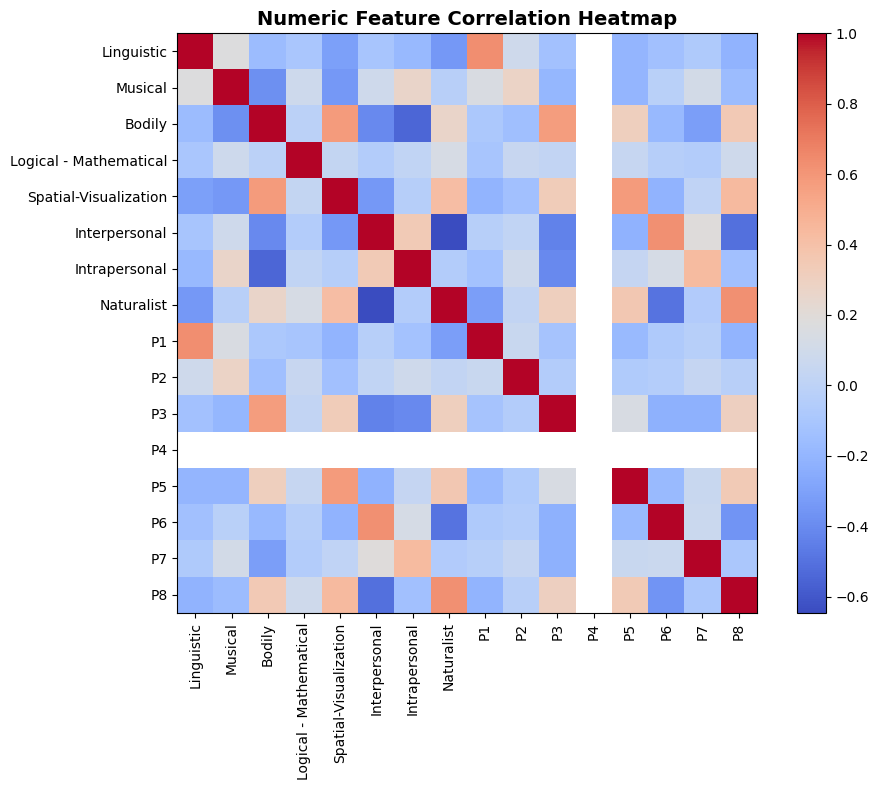

Correlation heatmap saved!


In [15]:
if len(numeric_cols) >= 2:
    print("\nGenerating correlation heatmap...")
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Numeric Feature Correlation Heatmap", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "correlation_heatmap.png"), dpi=300)
    plt.show()
    print("Correlation heatmap saved!")

## 3.8 Outlier Detection (IQR Method)

In [16]:
print("\n" + "=" * 80)
print(" OUTLIER DETECTION")
print("=" * 80)

outlier_report = []
for c in numeric_cols:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or np.isnan(iqr):
        continue
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = df[(df[c] < lower) | (df[c] > upper)].shape[0]
    outlier_report.append((c, n_out, df[c].isna().sum()))

outlier_df = pd.DataFrame(outlier_report, columns=["feature", "n_outliers", "n_missing"])
outlier_df.to_csv(os.path.join(OUT_DIR, "outlier_report.csv"), index=False)
print(outlier_df)
print("\n Outlier report saved!")



 OUTLIER DETECTION
                   feature  n_outliers  n_missing
0               Linguistic           0          0
1                  Musical         295          0
2                   Bodily           0          0
3   Logical - Mathematical           0          0
4    Spatial-Visualization           0          0
5            Interpersonal           0          0
6            Intrapersonal           0          0
7               Naturalist           0          0
8                       P1           0          0
9                       P2           0          0
10                      P3         308          0
11                      P5         273          0
12                      P6           0          0
13                      P7           0          0
14                      P8         535          0

 Outlier report saved!


# 4. Data Preprocessing

Prepare the data for machine learning by:
* Converting intelligence scores to numeric
* Selecting relevant features
* Creating preprocessing pipelines for numeric and categorical features

# 4.1 Convert Intelligence Columns to Numeric

In [17]:
intelligence_cols = ['Linguistic','Musical','Bodily','Logical - Mathematical',
                     'Spatial-Visualization','Interpersonal','Intrapersonal','Naturalist']

for c in intelligence_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print(" Intelligence columns converted to numeric")

 Intelligence columns converted to numeric


# 4.2 Feature Selection

In [18]:
numeric_feats = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_feats:
    numeric_feats.remove(TARGET_COL)

categorical_all = [c for c in cat_cols if c in df.columns]
categorical_feats = [c for c in categorical_all if df[c].nunique() <= 20]

print(f"Selected {len(numeric_feats)} numeric features")
print(f"Selected {len(categorical_feats)} categorical features (cardinality ≤ 20)")
print(f"\n Numeric features: {numeric_feats}")
print(f"Categorical features: {categorical_feats}")

Selected 16 numeric features
Selected 1 categorical features (cardinality ≤ 20)

 Numeric features: ['Linguistic', 'Musical', 'Bodily', 'Logical - Mathematical', 'Spatial-Visualization', 'Interpersonal', 'Intrapersonal', 'Naturalist', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
Categorical features: ['Course']


# 4.3 Create Feature Matrix and Target Vector

In [19]:
X = df[numeric_feats + categorical_feats].copy()
y = df[TARGET_COL].astype(str).copy()

print(f"\n Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


 Feature matrix shape: (3000, 17)
Target vector shape: (3000,)


# 4.4 Build Preprocessing Pipeline

In [20]:
# Numeric transformer: Impute missing values with median, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical transformer: Impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_feats),
    ("cat", categorical_transformer, categorical_feats)
], remainder='drop')

print("\nPreprocessing pipeline created!")
print("   • Numeric: Median imputation → Standard scaling")
print("   • Categorical: Mode imputation → One-hot encoding")


Preprocessing pipeline created!
   • Numeric: Median imputation → Standard scaling
   • Categorical: Mode imputation → One-hot encoding


# 5. Exploratory Data Analysis (EDA)
visualize the data to understand distributions, relationships, and patterns.


# 5.1 Target Class Distribution

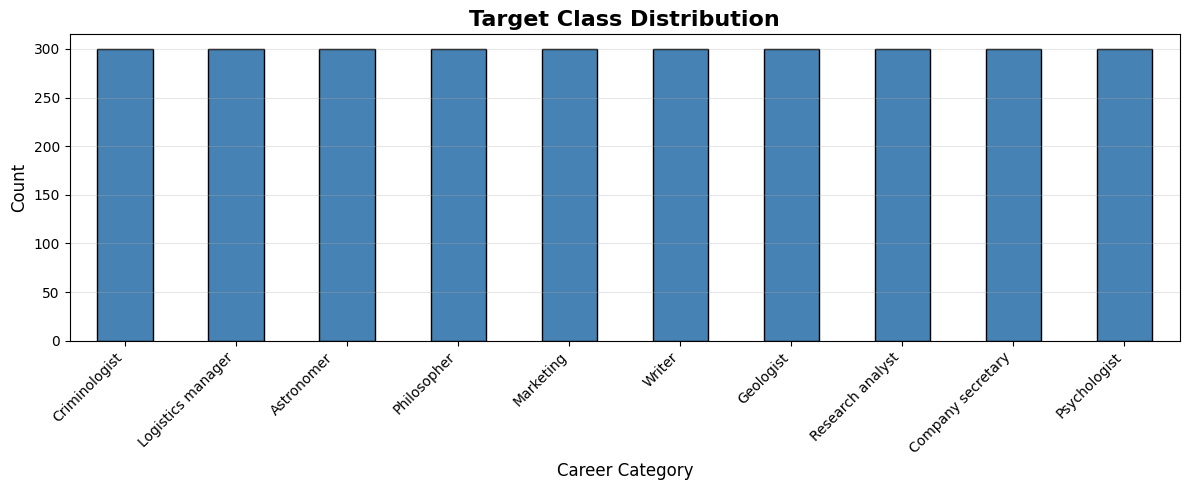

Class distribution plot saved!


In [21]:
plt.figure(figsize=(12, 5))
y.value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Target Class Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Career Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_class_distribution.png"), dpi=300)
plt.show()
print("Class distribution plot saved!")

# 5.2 Numeric Feature Distributions (Histograms)


Generating histograms for numeric features...


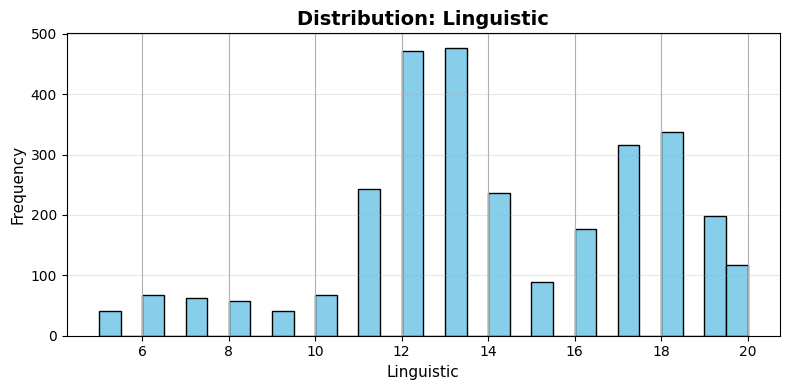

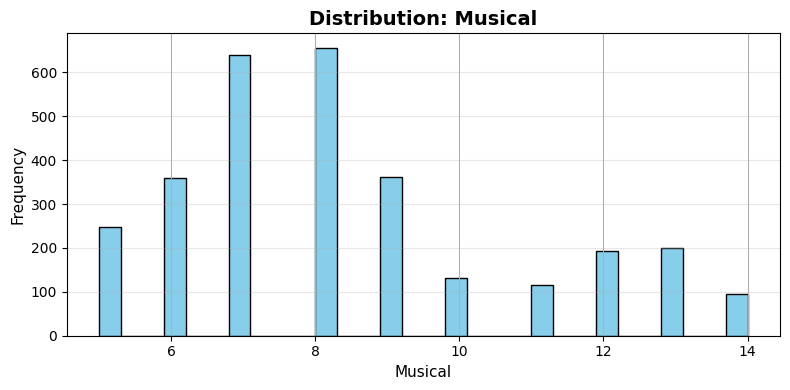

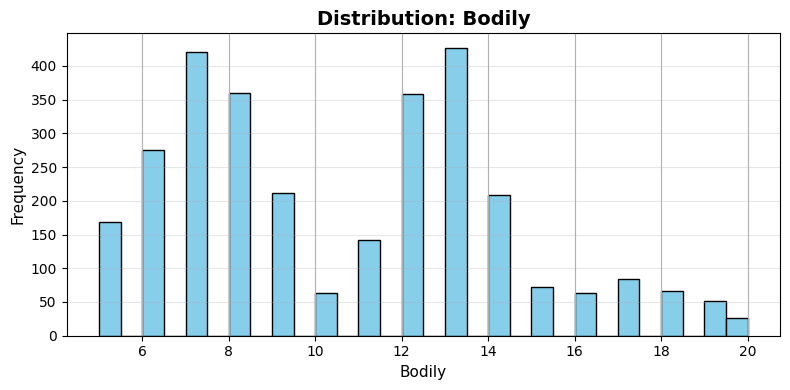

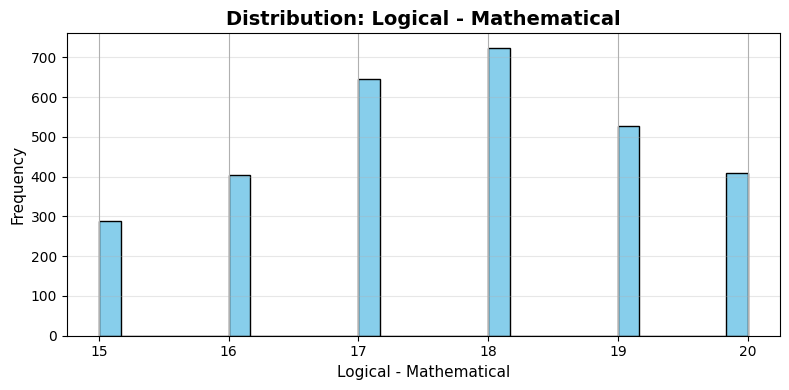

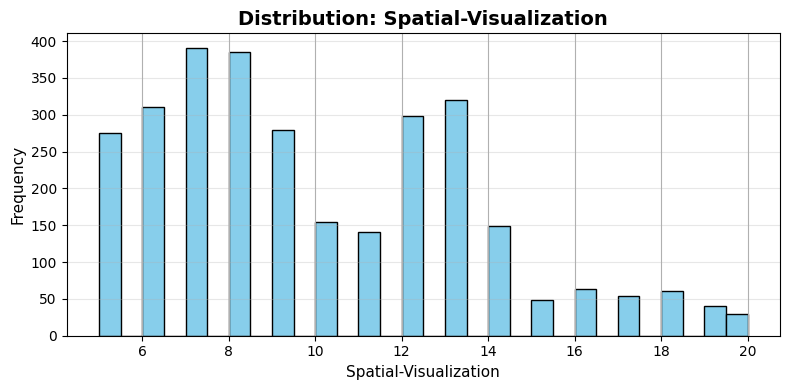

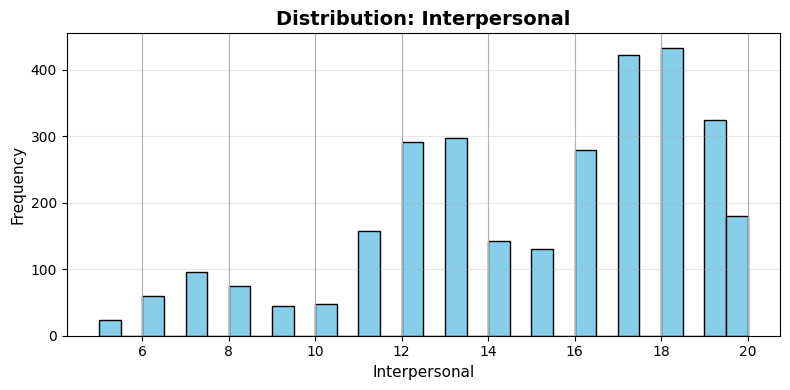

Histograms saved!


In [22]:
print("\nGenerating histograms for numeric features...")
for i, col in enumerate(numeric_feats[:6]):
    plt.figure(figsize=(8, 4))
    df[col].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution: {col}", fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=11)
    plt.ylabel("Frequency", fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"hist_{col}.png"), dpi=300)
    plt.show()
print("Histograms saved!")

# 5.3 Numeric Feature Distributions (Boxplots)


Generating boxplots for numeric features...


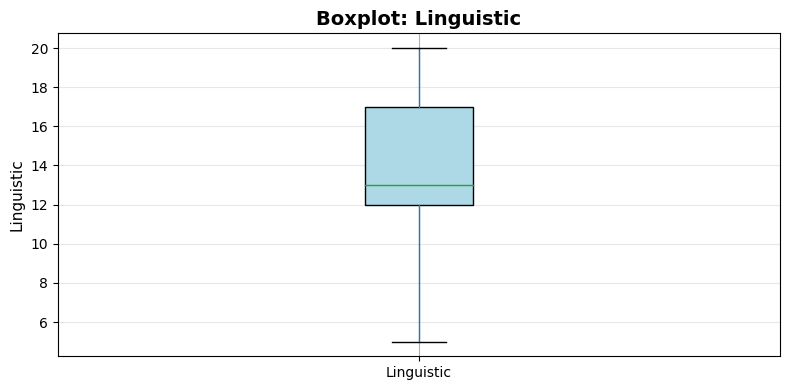

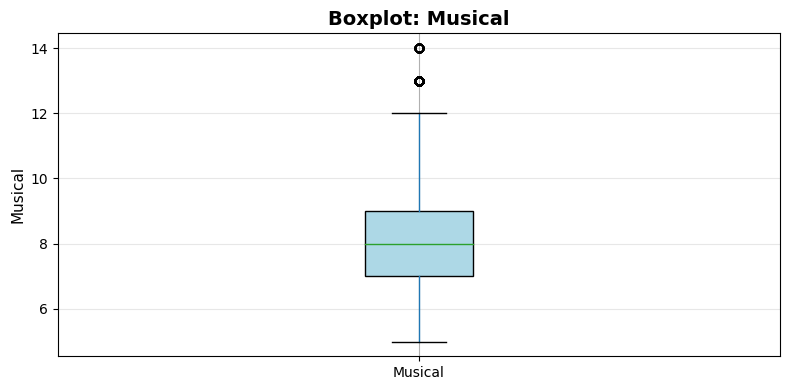

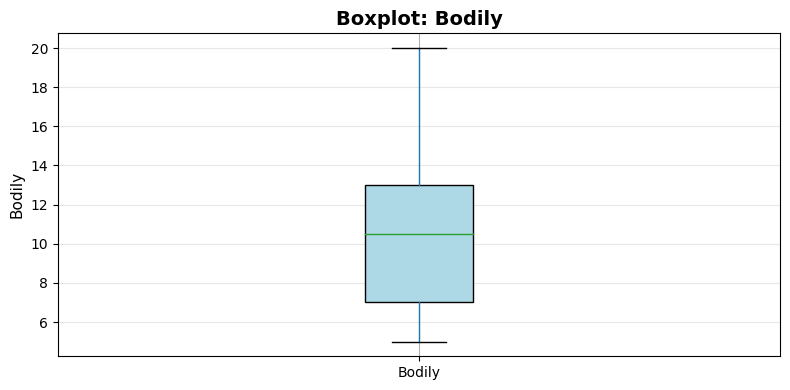

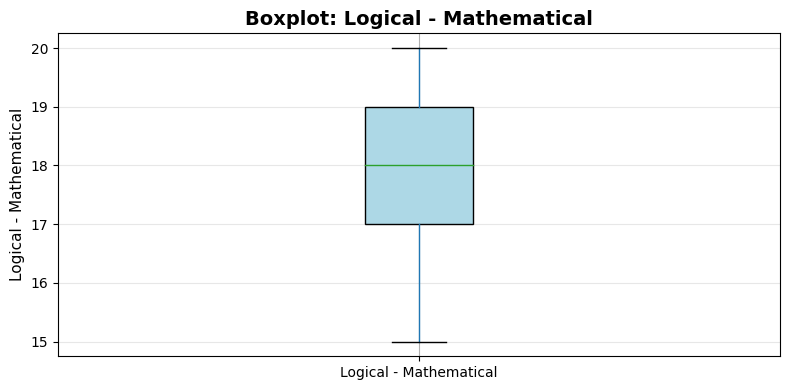

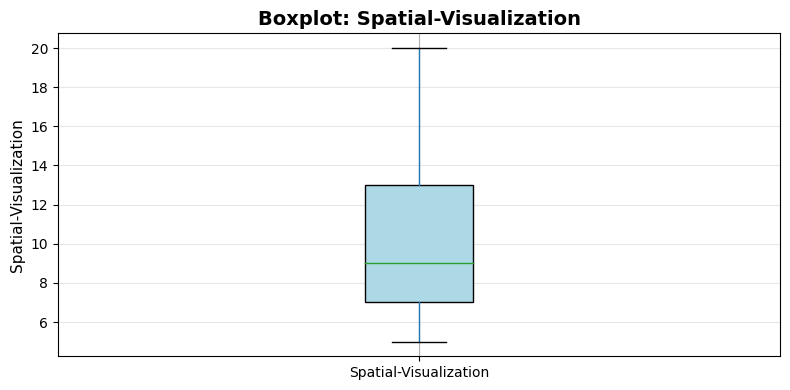

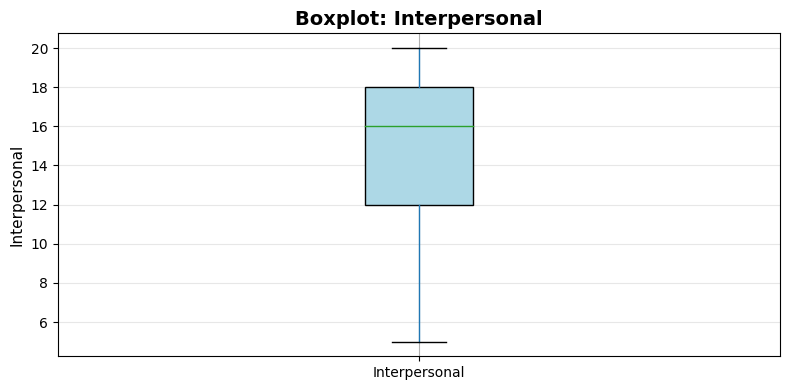

Boxplots saved!


In [23]:
print("\nGenerating boxplots for numeric features...")
for col in numeric_feats[:6]:
    plt.figure(figsize=(8, 4))
    df.boxplot(column=col, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Boxplot: {col}", fontsize=14, fontweight='bold')
    plt.ylabel(col, fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"box_{col}.png"), dpi=300)
    plt.show()
print("Boxplots saved!")

# 5.4 PCA 2D Visualization


📊 Generating PCA 2D visualization...


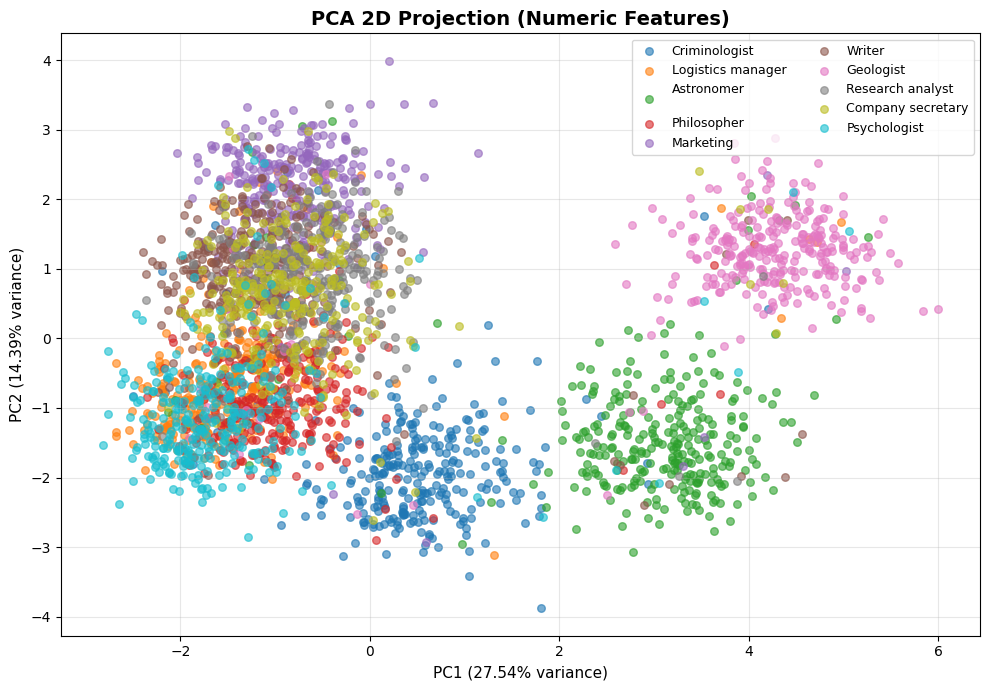

PCA plot saved!


In [24]:
if len(numeric_feats) >= 2:
    try:
        print("\n📊 Generating PCA 2D visualization...")
        scaled_numeric = StandardScaler().fit_transform(df[numeric_feats].fillna(df[numeric_feats].median()))
        pca = PCA(n_components=2, random_state=SEED)
        pca2 = pca.fit_transform(scaled_numeric)
        
        plt.figure(figsize=(10, 7))
        unique_targets = y.unique()
        for t in unique_targets[:10]:
            idx = y == t
            plt.scatter(pca2[idx, 0], pca2[idx, 1], label=str(t), s=30, alpha=0.6)
        plt.legend(loc='best', fontsize=9, ncol=2)
        plt.title("PCA 2D Projection (Numeric Features)", fontsize=14, fontweight='bold')
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)", fontsize=11)
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)", fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "pca_2d.png"), dpi=300)
        plt.show()
        print("PCA plot saved!")
    except Exception as e:
        print(f"PCA plot failed: {e}")

# 6. Model Training & Hyperparameter Tuning
We'll train **3 different algorithms** with hyperparameter tuning using GridSearchCV:

1. **Random Forest Classifier**
2. **Gradient Boosting Classifier**
3. **Logistic Regression**


# 6.1 Train/Test Split (Stratified)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Data split complete!")
print(f"   • Training set: {X_train.shape[0]:,} samples")
print(f"   • Test set: {X_test.shape[0]:,} samples")
print(f"   • Train ratio: {X_train.shape[0]/len(X):.1%}")
print(f"   • Test ratio: {X_test.shape[0]/len(X):.1%}")

Data split complete!
   • Training set: 2,400 samples
   • Test set: 600 samples
   • Train ratio: 80.0%
   • Test ratio: 20.0%


# 6.2 Define Model Pipelines & Hyperparameter Grids

In [26]:
models_to_run = {}

# Random Forest

In [27]:
rf_pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])
rf_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_split": [2, 5]
}
models_to_run["RandomForest"] = (rf_pipeline, rf_param_grid)

# Gradient Boosting

In [28]:
gb_pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=SEED))
])
gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 5]
}
models_to_run["GradientBoosting"] = (gb_pipeline, gb_param_grid)

# Logistic Regression

In [29]:
lr_pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=SEED))
])
lr_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["lbfgs"]
}
models_to_run["LogisticRegression"] = (lr_pipeline, lr_param_grid)

In [30]:
print(f"\n✅ Defined {len(models_to_run)} model pipelines with hyperparameter grids")


✅ Defined 3 model pipelines with hyperparameter grids


# 6.3 GridSearchCV with Cross-Validation

In [31]:
results_summary = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING & CROSS-VALIDATION")
print("=" * 80)

for name, (pipeline, param_grid) in models_to_run.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    
    print(f"\nBest parameters: {gs.best_params_}")
    joblib.dump(best, os.path.join(OUT_DIR, f"best_model_{name}.joblib"))
    


HYPERPARAMETER TUNING & CROSS-VALIDATION

Training: RandomForest
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp


Best parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

Training: GradientBoosting
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp


Best parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}

Training: LogisticRegression
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp


Best parameters: {'clf__C': 0.1, 'clf__solver': 'lbfgs'}


# Save model

# Cross-validated accuracy

In [32]:
cv_scores = cross_val_score(best, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"   Min: {cv_scores.min():.4f} | Max: {cv_scores.max():.4f}")
    
results_summary.append({
        "model": name,
        "best_params": gs.best_params_,
        "cv_accuracy_mean": float(np.round(cv_scores.mean(), 6)),
        "cv_accuracy_std": float(np.round(cv_scores.std(), 6))
})

CV Accuracy: 0.8908 ± 0.0155
   Min: 0.8775 | Max: 0.9125


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Save summary

In [33]:
pd.DataFrame(results_summary).to_csv(os.path.join(OUT_DIR, "gridsearch_summary.csv"), index=False)
print("\n" + "=" * 80)
print("All models trained and saved!")
print("=" * 80)


All models trained and saved!


# 7. Model Evaluation
Evaluate each model on the test set with comprehensive metrics and visualizations.

# 7.1 Define Evaluation Function

In [34]:
def evaluate_model(model, X_test, y_test, model_name):
    # Try to get probabilities
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        else:
            # Calibrate if needed (SVC etc.). Use CalibratedClassifierCV wrapper
            calibrated = CalibratedClassifierCV(model, cv=3)
            calibrated.fit(X_train, y_train)  # NOTE: uses outer scope X_train, y_train
            y_prob = calibrated.predict_proba(X_test)
            model = calibrated  # use calibrated model for predict
    except Exception:
        y_prob = None

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Save confusion matrix image
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.colorbar()
    classes = sorted(list(set(y_test)))
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"confusion_{model_name}.png"))
    plt.close()

    # Multiclass ROC-AUC (One-vs-Rest)
    roc_auc_macro_val = None
    if y_prob is not None:
        try:
            # label binarize
            classes_sorted = sorted(list(set(y_test)))
            y_test_bin = label_binarize(y_test, classes=classes_sorted)
            # If predict_proba columns ordering equals classifier classes_
            # map appropriate columns
            # compute fpr/tpr per class
            fpr = dict(); tpr = dict(); roc_auc = dict()
            for i in range(y_test_bin.shape[1]):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            # macro-average
            all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in fpr:
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= len(fpr)
            fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
            roc_auc_macro_val = roc_auc["macro"]

            # Plot ROC
            plt.figure(figsize=(10, 8))
            for i in range(len(classes_sorted)):
                plt.plot(fpr[i], tpr[i], lw=1, label=f"{classes_sorted[i]} (AUC={roc_auc[i]:.2f})")
            plt.plot(fpr["macro"], tpr["macro"], color='k', lw=2, label=f"Macro-average (AUC={roc_auc['macro']:.2f})")
            plt.plot([0, 1], [0, 1], 'k--', lw=1)
            plt.xlim([-0.01, 1.01])
            plt.ylim([-0.01, 1.01])
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title(f"Multiclass ROC ({model_name})")
            plt.legend(loc='lower right', fontsize='small')
            plt.tight_layout()
            plt.savefig(os.path.join(OUT_DIR, f"roc_{model_name}.png"))
            plt.close()
        except Exception as e:
            print("ROC computation failed for", model_name, e)

    # Save metrics to CSV
    metrics = {
        "model": model_name,
        "accuracy": float(np.round(acc, 6)),
        "precision_macro": float(np.round(prec_macro, 6)),
        "recall_macro": float(np.round(rec_macro, 6)),
        "f1_macro": float(np.round(f1_macro, 6)),
        "cohen_kappa": float(np.round(kappa, 6)),
        "mcc": float(np.round(mcc, 6)),
        "roc_auc_macro": None if roc_auc_macro_val is None else float(np.round(roc_auc_macro_val, 6)),
        "test_samples": int(len(y_test))
    }
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(OUT_DIR, f"metrics_summary_{model_name}.csv"), index=False)

    # Per-class metrics
    per_prec, per_rec, per_f1, per_sup = precision_recall_fscore_support(y_test, y_pred, average=None)
    per_df = pd.DataFrame({
        "class": sorted(list(set(y_test))),
        "precision": per_prec,
        "recall": per_rec,
        "f1": per_f1,
        "support": per_sup
    })
    per_df.to_csv(os.path.join(OUT_DIR, f"metrics_per_class_{model_name}.csv"), index=False)

    # Print summary
    print(f"--- {model_name} test results ---")
    print("Accuracy:", acc)
    print("Macro F1:", f1_macro)
    print("Cohen's Kappa:", kappa)
    print("MCC:", mcc)
    print("Top lines of classification report:")
    print(classification_report(y_test, y_pred, digits=4))
    return {
        "model": model_name,
        "estimator": model,
        "metrics": metrics,
        "y_pred": y_pred,
        "y_prob": y_prob
    }


# 7.2 Evaluate All Models

In [35]:
print("\n" + "=" * 80)
print("EVALUATING MODELS ON TEST SET")
print("=" * 80)

evaluation_results = []
for name in models_to_run.keys():
    model_path = os.path.join(OUT_DIR, f"best_model_{name}.joblib")
    if not os.path.exists(model_path):
        print(f"Model file missing for {name}, skipping...")
        continue
    
    model = joblib.load(model_path)
    eval_res = evaluate_model(model, X_test, y_test, name)
    evaluation_results.append(eval_res)

print("\nAll models evaluated!")


EVALUATING MODELS ON TEST SET
--- RandomForest test results ---
Accuracy: 0.895
Macro F1: 0.8949943918990348
Cohen's Kappa: 0.8833333333333333
MCC: 0.8834669541812137
Top lines of classification report:
                   precision    recall  f1-score   support

      Astronomer
     0.8947    0.8500    0.8718        60
Company secretary     0.9138    0.8833    0.8983        60
    Criminologist     0.9194    0.9500    0.9344        60
        Geologist     0.9322    0.9167    0.9244        60
Logistics manager     0.9310    0.9000    0.9153        60
        Marketing     0.9180    0.9333    0.9256        60
      Philosopher     0.8154    0.8833    0.8480        60
     Psychologist     0.8909    0.8167    0.8522        60
 Research analyst     0.8462    0.9167    0.8800        60
           Writer     0.9000    0.9000    0.9000        60

         accuracy                         0.8950       600
        macro avg     0.8962    0.8950    0.8950       600
     weighted avg     0.896

# 7.3 Sample Predictions with Probabilities

In [36]:
print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS (First 5 Test Samples)")
print("=" * 80)

for res in evaluation_results:
    name = res["model"]
    model = res["estimator"]
    
    print(f"\n{'─'*80}")
    print(f"Model: {name}")
    print(f"{'─'*80}")
    
    sample_X = X_test.iloc[:SAMPLE_PRED_COUNT]
    sample_y_true = y_test.iloc[:SAMPLE_PRED_COUNT]
    sample_pred = model.predict(sample_X)
    
    # Display predictions
    pred_df = pd.DataFrame({
        "True Label": sample_y_true.values,
        "Predicted Label": sample_pred,
        "Match": ["✓" if t == p else "✗" for t, p in zip(sample_y_true.values, sample_pred)]
    })
    print(pred_df.to_string(index=True))
    
    # Show probabilities
    if res["y_prob"] is not None:
        probs = model.predict_proba(sample_X)
        topk = np.argsort(probs, axis=1)[:, ::-1][:, :3]
        classes = sorted(list(set(y_test)))
        
        print("\n Top-3 Predicted Class Probabilities:")
        for i, row in enumerate(probs):
            top = [(classes[idx], float(np.round(row[idx], 4))) for idx in topk[i]]
            print(f"   Sample {i}: {top}")


SAMPLE PREDICTIONS (First 5 Test Samples)

────────────────────────────────────────────────────────────────────────────────
Model: RandomForest
────────────────────────────────────────────────────────────────────────────────
          True Label    Predicted Label Match
0  Logistics manager  Logistics manager     ✓
1       Astronomer\n          Geologist     ✗
2  Company secretary  Company secretary     ✓
3  Logistics manager  Logistics manager     ✓
4             Writer             Writer     ✓

 Top-3 Predicted Class Probabilities:
   Sample 0: [('Logistics manager', 0.865), ('Psychologist', 0.06), ('Marketing', 0.035)]
   Sample 1: [('Geologist', 0.695), ('Criminologist', 0.07), ('Astronomer\n', 0.07)]
   Sample 2: [('Company secretary', 0.825), ('Geologist', 0.07), ('Psychologist', 0.05)]
   Sample 3: [('Logistics manager', 0.895), ('Company secretary', 0.04), ('Psychologist', 0.035)]
   Sample 4: [('Writer', 0.98), ('Company secretary', 0.01), ('Geologist', 0.005)]

─────────────

# 8. Results & Comparison

MODEL PERFORMANCE COMPARISON

✅ Comparison table saved!


/tmp/ipykernel_47/4119563250.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models, rotation=15, ha='right')


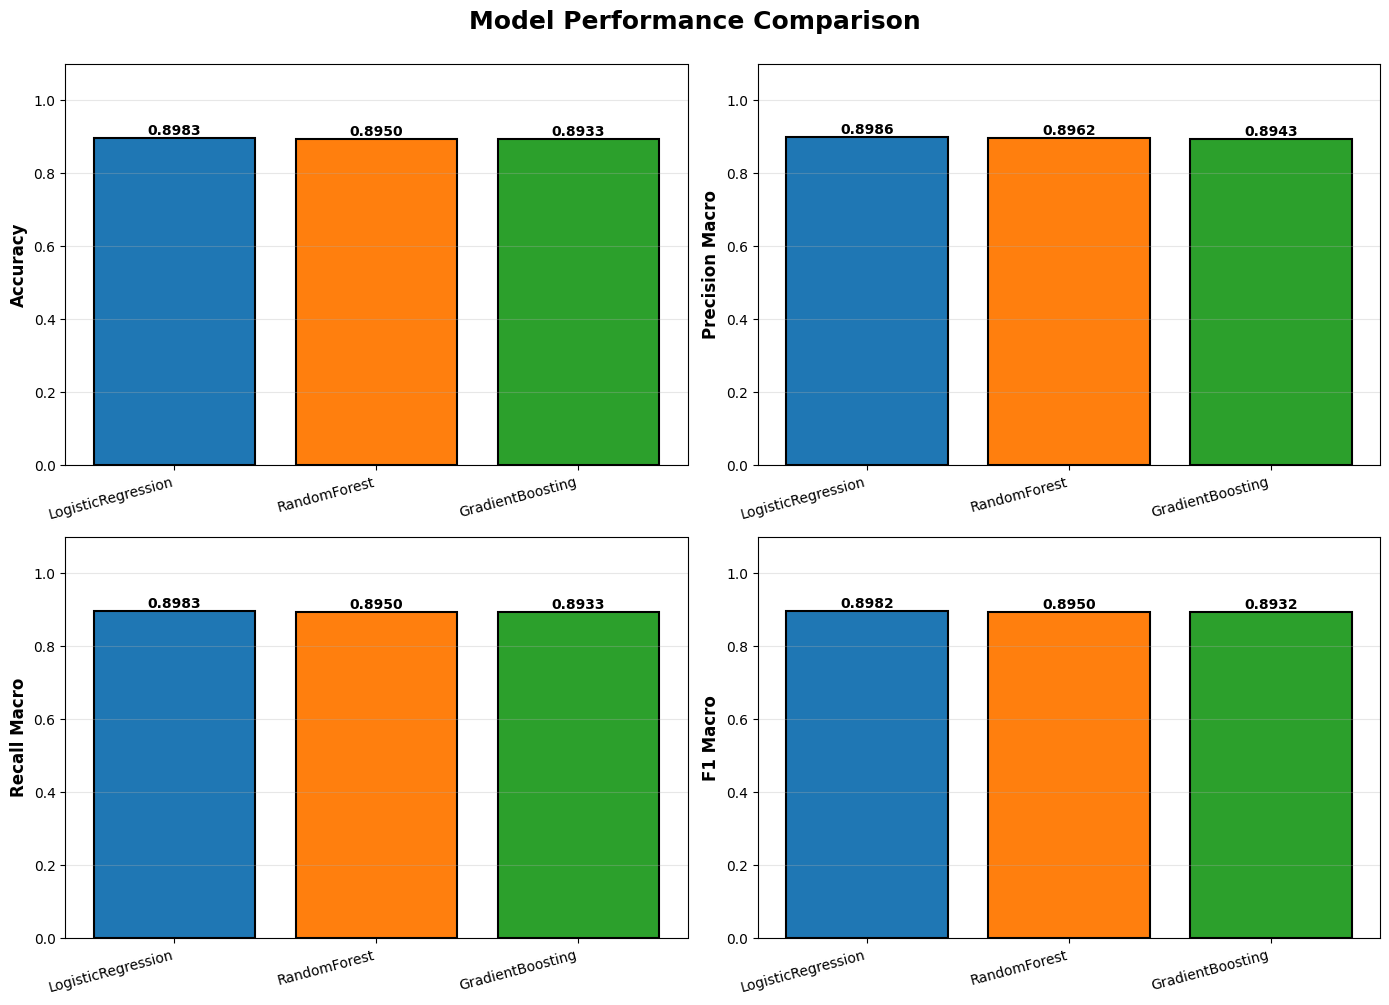

Comparison chart saved!

BEST MODEL
Model:     LogisticRegression
Accuracy:  0.8983
F1 Score:  0.8982


In [37]:
summary_list = []
for res in evaluation_results:
    summary_list.append(res["metrics"])

comparison_df = pd.DataFrame(summary_list)
comparison_df = comparison_df.sort_values("accuracy", ascending=False)

print("=" * 80)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 80)
comparison_df

# Save comparison
comparison_df.to_csv(os.path.join(OUT_DIR, "final_models_comparison.csv"), index=False)
print("\n✅ Comparison table saved!")

# ## 8.2 Visual Comparison

# Prepare data for plotting
models = comparison_df['model'].values
metrics_to_plot = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Model Performance Comparison", fontsize=18, fontweight='bold', y=1.00)

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(models, rotation=15, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "models_comparison_chart.png"), dpi=300, bbox_inches='tight')
plt.show()
print("Comparison chart saved!")

# ## 8.3 Best Model Selection

best_model_name = comparison_df.iloc[0]['model']
best_accuracy = comparison_df.iloc[0]['accuracy']
best_f1 = comparison_df.iloc[0]['f1_macro']

print("\n" + "=" * 80)
print("BEST MODEL")
print("="* 80)
print(f"Model:     {best_model_name}")
print(f"Accuracy:  {best_accuracy:.4f}")
print(f"F1 Score:  {best_f1:.4f}")
print("=" * 80)